In [14]:
from scipy.io import loadmat
import mat73
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np
from tqdm import notebook
from scipy import stats
from scipy.signal import hilbert
from scipy.signal import butter, sosfiltfilt
from scipy import signal
from scipy.fft import fftshift
from kneed import KneeLocator
import pickle
import joblib
import os
import sys
sys.path.append('../libraries/') # Append the path within which the user-defined class is in
from data_loader import data_loader
from behavior_loader import bsoid_loader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [15]:
data_dir = r'../processed_data'

### Load 1-hour l5 spikes

In [19]:
with open(os.path.join(data_dir, 'm1_fr0.1hz_30hz_0s_7200s_0.1s_bins_nooverlap.sav'), 'rb') as file:
    spike_times_all_neurons = joblib.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# Transpose into (71999, 90)
spike_times_all_neurons = spike_times_all_neurons.T

# Truncate 2-four m1 recording to 1-hour l5 recording into (36000, 46), 
# 0th to 45th L5/6, 46th to 89th L2/3, 89th being the most shallow
spike_times_l5_neurons_1h = spike_times_all_neurons[:36000, :46]

# # (Number of 100-ms bins, Number of l2 neurons)
# T_1h, D_m1 = spike_times_all_neurons_1h.shape

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_l5_neurons_1h_zscored = stats.zscore(spike_times_l5_neurons_1h) # Default axis is 0

spikes = spike_times_l5_neurons_1h_zscored
print(f'Spike times are binned into shape: {spikes.shape}')

Spike times are binned into shape: (36000, 46)


### Load 1-hour z-scored bandpower features of lpf using Welch method

In [78]:
zscore_feats = pickle.load(open(os.path.join(data_dir, 'welch_band_pow_zscore.np'), 'rb')).T
print(f'Z-scored bandpower features are binned into shape: {zscore_feats.shape}')

Z-scored bandpower features are binned into shape: (36000, 156)


### Load best hmm model that seperates lpf most clearly and predict on lpf features

In [79]:
K = 6
hmm_best = pickle.load(open(f'../hmm_models/hmm_welch/hmm_lpf_{K}_states.hmm', 'rb'))
hmm_states = hmm_best.predict(zscore_feats)[::int(zscore_feats.shape[0]/spikes.shape[0])]

### Load 1-hour behaviors

In [80]:
# Load behaviors
behavior_loader = bsoid_loader(data_dir, 'ag25290_day2_iter13')
f_index, filtered_data, smoothed_predictions = behavior_loader.main()

# Correct prediction start
framerate = 60
delay = 6.8503
behavior_start = int(delay * framerate)  # start of behavior
smoothed_predictions_1h = smoothed_predictions[behavior_start:(behavior_start+3600*60):int(60/10)]

Mouse stayed in nest for 0.28108749470484795% of time
Smooth window: 6
File #0 (a 6 body parts by 984391 frames) has 30 classes


In [81]:
behav_names_mod = ['insignificant', 'insignificant', 'insignificant', 'insignificant', 'rear',
         'insignificant', 'insignificant', 'investigate type 1', 'investigate type 2', 'contra-itch',
         'investigate type 3', 'insignificant', 'insignificant', 'insignificant', 'contra-body groom',
         'face groom type 1', 'dive/scrunch', 'head groom', 'ipsi-orient', 'insignificant',
         'face groom type 2', 'ipsi-body groom', 'ipsi-itch type 1', 'insignificant', 'insignificant', 
         'paw groom', 'locomotion', 'insignificant', 'contra-orient']

### Classify behaviors within hmm states

In [82]:
def data_seg_prepare(data, targets, spikes, smoothed_predictions, random_state=10, limit_count=100, verbose=False):
    X = data.copy()
    y = targets.copy()
    X_subsampled = []
    y_subsampled = []
    spikes_subsampled = []
    smoothed_predictions_subsampled = []

    rng = np.random.default_rng(random_state)
    sig_behavs = [i for i, s in enumerate(behav_names_mod) if s != 'insignificant']
    for sig_behav in sig_behavs:
        idcs_s = np.where(y == sig_behav)[0]
        idcs_s_all = np.where(smoothed_predictions_1h == sig_behav)[0]
        try:
            sampled_idcs_s = rng.choice(len(idcs_s), limit_count, replace=False)
            sampled_idcs_s_all = rng.choice(len(idcs_s_all), limit_count, replace=False)
        except:
            sampled_idcs_s = rng.choice(len(idcs_s), len(idcs_s), replace=False)
            sampled_idcs_s_all = rng.choice(len(idcs_s_all), len(idcs_s), replace=False)
        y_subsampled.append(y[idcs_s[sampled_idcs_s]])
        X_subsampled.append(X[idcs_s[sampled_idcs_s], :])          
        smoothed_predictions_subsampled.append(smoothed_predictions[idcs_s_all[sampled_idcs_s_all]])
        spikes_subsampled.append(spikes[idcs_s_all[sampled_idcs_s_all], :])
            
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)

    return np.hstack(y_subsampled), np.vstack(X_subsampled), np.hstack(smoothed_predictions_subsampled), np.vstack(spikes_subsampled)

In [ ]:
config = []
rf_score_offset_arr = []
for state in range(100):
  reducer = umap.UMAP(n_components=5, n_neighbors=60, min_dist=0, random_state=state)
  embedding = reducer.fit_transform(zscore_feats.T)
  for min_cluster_size in range(150, 301, 50):
    for min_samples in range(15, 21, 5):
      clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True).fit(embedding)
      X = zscore_feats[:, clusterer_umap.labels_ >= 0]
      y = clusterer_umap.labels_[clusterer_umap.labels_ >= 0]
      clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
      clf.fit(X.T, y)
      y_all = clf.predict(zscore_feats.T)
      _, rf_f1_score = rf_f1_score(zscore_feats.T, y_all, test_size=0.2, average_type='macro')
      rf_f1_score_offset = rf_f1_score - (1 / len(np.unique(y_all)))
      rf_score_offset_arr.append(rf_f1_score_offset)
      config.append({'umap_state': state,
                     'min_cluster_size': min_cluster_size,
                     'min_samples': min_samples,
                     'rf_f1_score_offset': rf_f1_score_offset})

In [85]:
def rf_f1_score(X, y, test_size=0.2):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=42)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    print(np.unique(y_train, return_counts=True))
    predict = clf.predict(X_test)

    return np.unique(y_test), f1_score(y_test, predict, average=None)

In [86]:
uiq_y_arr = []
f1_score_diff = []
f1_score_smooth_behav_arr = []
for hmm_state in np.unique(hmm_states):
    seg_idcs = np.where(hmm_states == hmm_state)[0]
    state_spikes = spikes[seg_idcs, :]
    state_smoothed_predictions_1h = smoothed_predictions_1h[seg_idcs]
    
    state_smoothed_predictions_subsampled, state_spikes_subsampled, smoothed_predictions_subsampled, spikes_subsampled = \
        data_seg_prepare(state_spikes, state_smoothed_predictions_1h, spikes, smoothed_predictions_1h, random_state=seed)
    
    uiq_y, f1_score_sep_behav = rf_f1_score(state_spikes_subsampled, state_smoothed_predictions_subsampled)
    uiq_y_arr.append(uiq_y)
    
    _, f1_score_smooth_behav = rf_f1_score(spikes_subsampled, smoothed_predictions_subsampled)

    f1_score_diff.append(f1_score_sep_behav - f1_score_smooth_behav)
    f1_score_smooth_behav_arr.append(f1_score_smooth_behav)

(array([ 7,  8,  9, 10, 15, 17, 18, 21, 25, 26, 28], dtype=int32), array([80, 80, 52, 79, 75, 56, 60, 64, 74, 80, 40]))
(array([ 7,  8,  9, 10, 15, 17, 18, 21, 25, 26, 28], dtype=int32), array([80, 80, 52, 79, 75, 56, 60, 64, 74, 80, 40]))
(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
      dtype=int32), array([18, 80, 80, 80, 48, 80, 80, 47, 80, 79, 80, 80, 51, 80, 80, 52]))
(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
      dtype=int32), array([18, 80, 80, 80, 48, 80, 80, 47, 80, 79, 80, 80, 51, 80, 80, 52]))
(array([ 7,  8, 10], dtype=int32), array([31, 80, 38]))
(array([ 7,  8, 10], dtype=int32), array([31, 80, 38]))
(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
      dtype=int32), array([42, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]))
(array([ 4,  7,  8,  9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 28],
      dtype=int32), array([42, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80

In [73]:
f1_score_diffs = []
f1_score_smooth_behav_arrs = []
for seed in notebook.tqdm(range(100, 201)):
    uiq_y_arr = []
    f1_score_diff = []
    f1_score_smooth_behav_arr = []
    for hmm_state in np.unique(hmm_states):
        seg_idcs = np.where(hmm_states == hmm_state)[0]
        state_spikes = spikes[seg_idcs, :]
        state_smoothed_predictions_1h = smoothed_predictions_1h[seg_idcs]
        
        state_smoothed_predictions_subsampled, state_spikes_subsampled, smoothed_predictions_subsampled, spikes_subsampled = \
            data_seg_prepare(state_spikes, state_smoothed_predictions_1h, spikes, smoothed_predictions_1h, random_state=seed)
        
        uiq_y, f1_score_sep_behav = rf_f1_score(state_spikes_subsampled, state_smoothed_predictions_subsampled)
        uiq_y_arr.append(uiq_y)
        
        _, f1_score_smooth_behav = rf_f1_score(spikes_subsampled, smoothed_predictions_subsampled)

        f1_score_diff.append(f1_score_sep_behav - f1_score_smooth_behav)
        f1_score_smooth_behav_arr.append(f1_score_smooth_behav)
    f1_score_smooth_behav_arrs.append(f1_score_smooth_behav_arr)
    f1_score_diffs.append(f1_score_diff)

  0%|          | 0/101 [00:00<?, ?it/s]

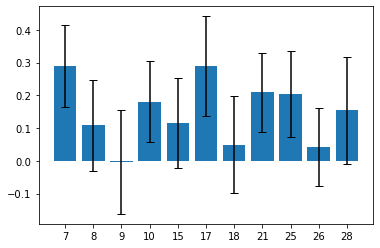

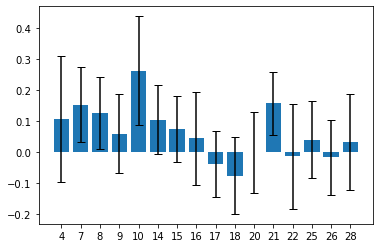

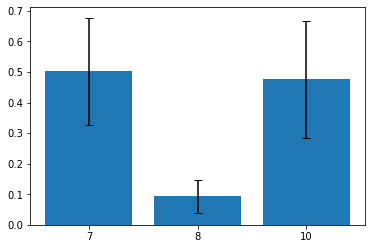

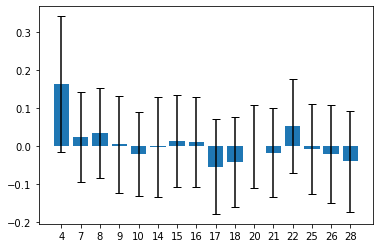

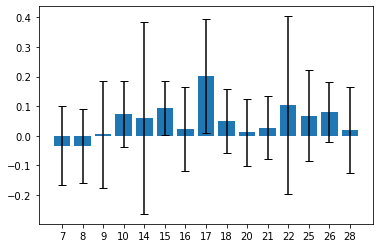

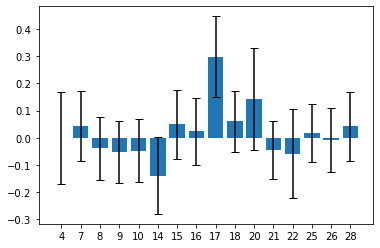

In [74]:
for i in range(len(np.unique(hmm_states))):
    state_f1_score_arr = []
    for f1_score_diff in f1_score_diffs:
        state_f1_score_arr.append(f1_score_diff[i])
    state_f1_score = np.vstack(state_f1_score_arr)
    state_f1_score_mean = np.mean(state_f1_score, axis=0)
    state_f1_score_std = np.std(state_f1_score, axis=0)

    plt.figure(i)
    plt.bar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean)
    plt.errorbar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean, yerr=state_f1_score_std, ecolor='black', capsize=4, fmt = ' ')
    plt.xticks(np.arange(len(uiq_y_arr[i])), uiq_y_arr[i])

predict body-groom rear degraded that are more 3-D

For Bad behavior look at video, 

behavoir trans into subtype and what it trans into

within state behaivor worse subtype has more variance than baseline

within state behaivor better subtype has more variance than baseline

worse behaviors are at decision boundary

explain the ones are doing better by linking to the trainsing beahvior previsojusly